In [1]:
import pandas as pd
import re
import random

import folium
import folium.plugins as plugins

In [84]:
df = pd.read_csv('./data/DataWorkshop.csv')

# manual fix
df.iloc[135253, df.columns.get_loc('GPS y')] = "49*56'569"

![](https://media.wiley.com/assets/7/87/0-7645-1622-1_0302.jpg)

## Konwersja HH.MM.SS.S -> DD

In [85]:
# https://stackoverflow.com/questions/33997361
def dms2dd(coord):
    """ GPS HH.MM.SS.S to DD (Decimal Degrees) conversion """
    c = re.findall(r"\w+", coord)
    degrees = float(c[0])
    minutes = float(c[1])
    if len(c) > 2:
        seconds = float(c[2])/10   
    else:
        seconds = 0
    
    dd = float(degrees) + (minutes)/60 + float(seconds)/(60*60)

    return dd

df['Lat'] = df['GPS y'].apply(lambda x : dms2dd(x)) # Latitude - N
df['Lon'] = df['GPS x'].apply(lambda x : dms2dd(x)) # Longitude - E

### Losowe sprawdzenie

In [86]:
def osm_url(i):
    lat = df.iloc[i].Lat
    lon = df.iloc[i].Lon
    print(f"http://www.openstreetmap.org/?mlat={lat}&mlon={lon}&zoom=20&layers=M")

r = random.randint(0,df.shape[0])

# wylosuj dowolny wiersz
print(df.iloc[r].Miejscowość,':', df.iloc[r].Ulica) 
osm_url(r)

PSZÓW : ROMUALDA TRAUGUTTA
http://www.openstreetmap.org/?mlat=50.042361111111106&mlon=18.40394444444444&zoom=20&layers=M


## Sprawdzenie błędnych wpisów GPS

In [87]:
def check_gps(x):
    # Usuń wszystkie liczby
    s = re.sub(r"\d+","", x)
    return s

df['GPSy'] = df['GPS y'].apply(lambda x : check_gps(x))
df['GPSx'] = df['GPS x'].apply(lambda x : check_gps(x))

In [88]:
# prawidłowe formatowanie: *'
print(df['GPSx'].unique(), df['GPSy'].unique())

["*'" "*''"] ["*'" "*'*" "*''"]


In [89]:
feats = ["Miejscowość","Ulica","Numer drogi", "GPS x", "GPS y","GPSx","GPSy", "Lat", "Lon"]
df[feats][(df['GPSy']=="**'") | (df['GPSy']=="*'*") | (df['GPSy']=="*''") | (df['GPSx']=="*''")]

,Miejscowość,Ulica,Numer drogi,GPS x,GPS y,GPSx,GPSy,Lat,Lon
31931,WODZISŁAW ŚLĄSKI,ARMII KRAJOWEJ,I2,18*28''05,50*00'471,*'',*',50.013083,18.466806
142857,JAWORZNO,NaN,A4,19*15'220,50*09'*01,*',*'*,50.150028,19.256111
149393,ŚWIĘTOCHŁOWICE,BYTOMSKA,P9800S,18*55'084,50*18''11,*',*'',50.300306,18.919000
161201,ZAWIERCIE,JÓZEFA PIŁSUDSKIEGO,P1726S,19*25'274,50*25''27,*',*'',50.417417,19.424278


In [91]:
gps_lst = df[feats][(df['GPSy']=="**'") | (df['GPSy']=="*'*") | (df['GPSy']=="*''") | (df['GPSx']=="*''")].index.to_numpy()

print(gps_lst)

# 31931 -  OK
# 135253 - GPS y : 49*56'569
# 142857 - OK
# 149393 - OK
# 161201 - NOK (ok 13 km)

for item in gps_lst:     
    osm_url(item)

[ 31931 142857 149393 161201]
http://www.openstreetmap.org/?mlat=50.013083333333334&mlon=18.466805555555553&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.15002777777778&mlon=19.25611111111111&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.30030555555555&mlon=18.919&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.41741666666666&mlon=19.424277777777778&zoom=20&layers=M


In [83]:
df.iloc[135253, df.columns.get_loc('GPS y')] = "49*56'569"
osm_url(135253)

http://www.openstreetmap.org/?mlat=49.94913888888888&mlon=18.59472222222222&zoom=20&layers=M


---

## Open Street Map

In [92]:
#bbox = left,bottom,right,top
#bbox = min Longitude , min Latitude , max Longitude , max Latitude 

bbox = [df['Lon'].min(),df['Lat'].min(), df['Lon'].max(),df['Lat'].max()]
bbox
# http://tools.geofabrik.de/calc/#type=geofabrik_standard&bbox=15.062306,4.949139,21.999083,55.015167&tab=1&proj=EPSG:4326&places=2

[15.062305555555556, 49.33419444444445, 21.999083333333335, 55.015166666666666]

In [93]:
cities = df['Miejscowość'].unique()
lst = cities.tolist()

# https://geocode.localfocus.nl/

# Hutki-Kanki ❤️

#for item in lst:
#    print(item)
    
with open('./data/cities_raw.txt', 'w', encoding="utf-8") as f:
    for city in lst:
        f.write("%s, Silesian Voivodeship, Poland\n" % city)

In [94]:
# http://tools.geofabrik.de/calc/#type=geofabrik_standard&bbox=18.035036,49.393978,19.974066,51.09943&tab=1&proj=EPSG:4326&places=4
# Silesian Voivodeship, Poland
# 18.035 49.3939 19.9741 51.0995

feats = ["Miejscowość","Ulica","Numer drogi", "GPS x", "GPS y","GPSx","GPSy", "Lat", "Lon"]
df[feats][(df['Lon'] < 18.035) | (df['Lat'] < 49.3939) | (df['Lon'] > 19.9741) | (df['Lat'] > 51.0995)]

,Miejscowość,Ulica,Numer drogi,GPS x,GPS y,GPSx,GPSy,Lat,Lon
15349,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,W902,19*59'033,50*16'087,*',*',50.269083,19.984250
20566,GLIWICE,LITERATÓW,I2,17*38'271,50*20'080,*',*',50.335556,17.640861
27105,OSINY,CZĘSTOCHOWSKA,791,19*23'227,51*33'157,*',*',51.554361,19.389639
32758,KONIECPOL,RYNEK,794,15*40'354,50*46'170,*',*',50.771389,15.676500
32880,ZABRZE,NaN,A4,21*59'567,50*20'277,*',*',50.341028,21.999083
34895,BONOWICE,NaN,78,16*46'322,50*37'081,*',*',50.618917,16.775611
37291,KATOWICE,NaN,A4,15*59'547,50*15'097,*',*',50.252694,15.998528
45271,KATOWICE,BRYNOWSKA,P6453S,19*59'452,50*14'025,*',*',50.234028,19.995889
49595,SKRZYDLÓW,GŁÓWNA,GMINNA,19*20'439,51*12'202,*',*',51.205611,19.345528
86014,MYKANÓW,NaN,1,19*20'260,50*90'457,*',*',51.512694,19.340556


In [103]:
idx = df[feats][(df['Lon']<18.035) | (df['Lat']<49.3939) | (df['Lon']>19.9741) | (df['Lat']>51.0995)].index.to_numpy()

print('Błędne dane: ', len(idx), '\nID wiersza:\n', idx)

for i in idx:     
    osm_url(i)

Błędne dane:  25 
ID wiersza:
 [ 15349  20566  27105  32758  32880  34895  37291  45271  49595  86014
 120955 122869 131415 134588 139483 145949 146928 147956 155437 160399
 161478 161915 162191 173479 203804]
http://www.openstreetmap.org/?mlat=50.269083333333334&mlon=19.98425&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.33555555555556&mlon=17.64086111111111&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=51.554361111111106&mlon=19.38963888888889&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.771388888888886&mlon=15.676499999999999&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.34102777777778&mlon=21.999083333333335&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.618916666666664&mlon=16.77561111111111&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.252694444444444&mlon=15.998527777777777&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=50.234027777777776&mlon=19.99588888888889&zoom=20&layers=M
http://www.openstreetmap.org/?mlat=51.20561111

In [128]:
from geopy.geocoders import Nominatim
import time

def geocode():
    columns = ['city', 'street','lat','lon', 'GPS x' ,'GPS y', 'nlat', 'nlon']
    df_ = pd.DataFrame(columns=columns)
    df_ = df_.fillna(0)
    geolocator = Nominatim(user_agent="Nominatim")

    for i in idx:
        city = str(df.iloc[i].Miejscowość)
        street = str(df.iloc[i].Ulica)
        lat =df.iloc[i].Lat
        lon = df.iloc[i].Lon
        gpsx = df.iloc[i]['GPS x']
        gpsy = df.iloc[i]['GPS y']
        if street.lower() != "nan":
            try:
                location = geolocator.geocode(f"{city}, {street}")
                nlat = location.latitude
                nlon = location.longitude
                # print(f"{city}, {street}", lat, lon, gpsx, gpsy, nlat, nlon)
                df_.loc[len(df_)] = [city, street, lat, lon, gpsx, gpsy, nlat, nlon]
            except:
                pass
            
        time.sleep(1)
    return df_
        
#df_ = geocode(idx)

,city,street,lat,lon,GPS x,GPS y,nlat,nlon
0,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,50.269083,19.984250,19*59'033,50*16'087,50.273753,18.964144
1,GLIWICE,LITERATÓW,50.335556,17.640861,17*38'271,50*20'080,50.336694,18.639382
2,OSINY,CZĘSTOCHOWSKA,51.554361,19.389639,19*23'227,51*33'157,52.061394,21.261390
3,KONIECPOL,RYNEK,50.771389,15.676500,15*40'354,50*46'170,50.772905,19.677011
4,KATOWICE,BRYNOWSKA,50.234028,19.995889,19*59'452,50*14'025,50.232173,18.995604
5,SKRZYDLÓW,GŁÓWNA,51.205611,19.345528,19*20'439,51*12'202,50.845276,19.331996
6,JAWORZNO,GRUNWALDZKA,55.012361,19.261250,19*15'405,55*00'445,50.225324,19.232160
7,KATOWICE,WALENTEGO ROŹDZIEŃSKIEGO,50.269194,15.062306,15*03'443,50*16'091,51.118707,16.926892
8,RYBNIK,JANA KOTUCZA,55.015167,18.529750,18*31'471,55*00'546,50.100700,18.535868
9,KATOWICE,KOLEJOWA,50.224806,19.985278,19*59'070,50*13'293,50.222018,18.989642


In [129]:
df_.to_csv(r'./data/geoloc.csv', index = True)

In [130]:
df_pd.read_csv('./data/geoloc.csv')
df_['dlat'] = df_['lat']-df_['nlat']
df_['dlon'] = df_['lon']-df_['nlon']
df_

,city,street,lat,lon,GPS x,GPS y,nlat,nlon,dlat,dlon
0,KATOWICE,TRASA NIKODEMA I JÓZEFA RENCÓW,50.269083,19.984250,19*59'033,50*16'087,50.273753,18.964144,-0.004670,1.020106
1,GLIWICE,LITERATÓW,50.335556,17.640861,17*38'271,50*20'080,50.336694,18.639382,-0.001138,-0.998521
2,OSINY,CZĘSTOCHOWSKA,51.554361,19.389639,19*23'227,51*33'157,52.061394,21.261390,-0.507033,-1.871751
3,KONIECPOL,RYNEK,50.771389,15.676500,15*40'354,50*46'170,50.772905,19.677011,-0.001516,-4.000511
4,KATOWICE,BRYNOWSKA,50.234028,19.995889,19*59'452,50*14'025,50.232173,18.995604,0.001855,1.000285
5,SKRZYDLÓW,GŁÓWNA,51.205611,19.345528,19*20'439,51*12'202,50.845276,19.331996,0.360335,0.013532
6,JAWORZNO,GRUNWALDZKA,55.012361,19.261250,19*15'405,55*00'445,50.225324,19.232160,4.787037,0.029090
7,KATOWICE,WALENTEGO ROŹDZIEŃSKIEGO,50.269194,15.062306,15*03'443,50*16'091,51.118707,16.926892,-0.849513,-1.864586
8,RYBNIK,JANA KOTUCZA,55.015167,18.529750,18*31'471,55*00'546,50.100700,18.535868,4.914466,-0.006118
9,KATOWICE,KOLEJOWA,50.224806,19.985278,19*59'070,50*13'293,50.222018,18.989642,0.002787,0.995636


https://towardsdatascience.com/measuring-pedestrian-accessibility-97900f9e4d56

## Mapa wysokości

In [39]:
gdf = pd.read_csv('./data/slaskie.txt',sep=" ", header=None)
gdf.columns = ["Lat", "Lon", "Height"]
gdf.tail(10)



,Lat,Lon,Height
1231693,494400.0,358900.0,185.75
1231694,494500.0,358900.0,186.03
1231695,494600.0,358900.0,184.26
1231696,494700.0,358900.0,181.72
1231697,494400.0,359000.0,184.91
1231698,494500.0,359000.0,183.97
1231699,494600.0,359000.0,181.34
1231700,494400.0,359100.0,182.52
1231701,494500.0,359100.0,186.43
1231702,494600.0,359100.0,193.41


In [24]:
prefix = 'P '  
 
with open(r'./data/slaskie.txt', 'r') as src:  
    with open(r'./data/p_slaskie.txt', 'w') as dest:  
        for line in src:
            l = line.split(' ')
            line = ' '.join(l[0:2])
            dest.write('%s%s\n' % (prefix, line.rstrip('\n')))

In [37]:
wdf = pd.read_csv('./data/wyniki.txt',sep=" ", header=None)
wdf.columns = ["Type","Lat", "Lon"]
wdf.tail(10)

,Type,Lat,Lon
1231693,W,52.2974,16.9302
1231694,W,52.2983,16.9301
1231695,W,52.2992,16.9301
1231696,W,52.3001,16.9301
1231697,W,52.2975,16.9317
1231698,W,52.2984,16.9316
1231699,W,52.2993,16.9316
1231700,W,52.2975,16.9331
1231701,W,52.2984,16.9331
1231702,W,52.2993,16.9330


In [61]:
wdf['Height'] = gdf['Height']
wdf['Color'] = (wdf['Height']/6).astype(int)
print(wdf['Height'].max())
print(wdf['Height'].min())

wdf

1489.05
175.21


,Type,Lat,Lon,Height,Color
0,W,52.2809,14.1554,952.05,158
1,W,52.2818,14.1553,924.51,154
2,W,52.2827,14.1552,922.93,153
3,W,52.2836,14.1551,918.80,153
4,W,52.2845,14.1550,911.67,151
...,...,...,...,...,...
1231698,W,52.2984,16.9316,183.97,30
1231699,W,52.2993,16.9316,181.34,30
1231700,W,52.2975,16.9331,182.52,30
1231701,W,52.2984,16.9331,186.43,31


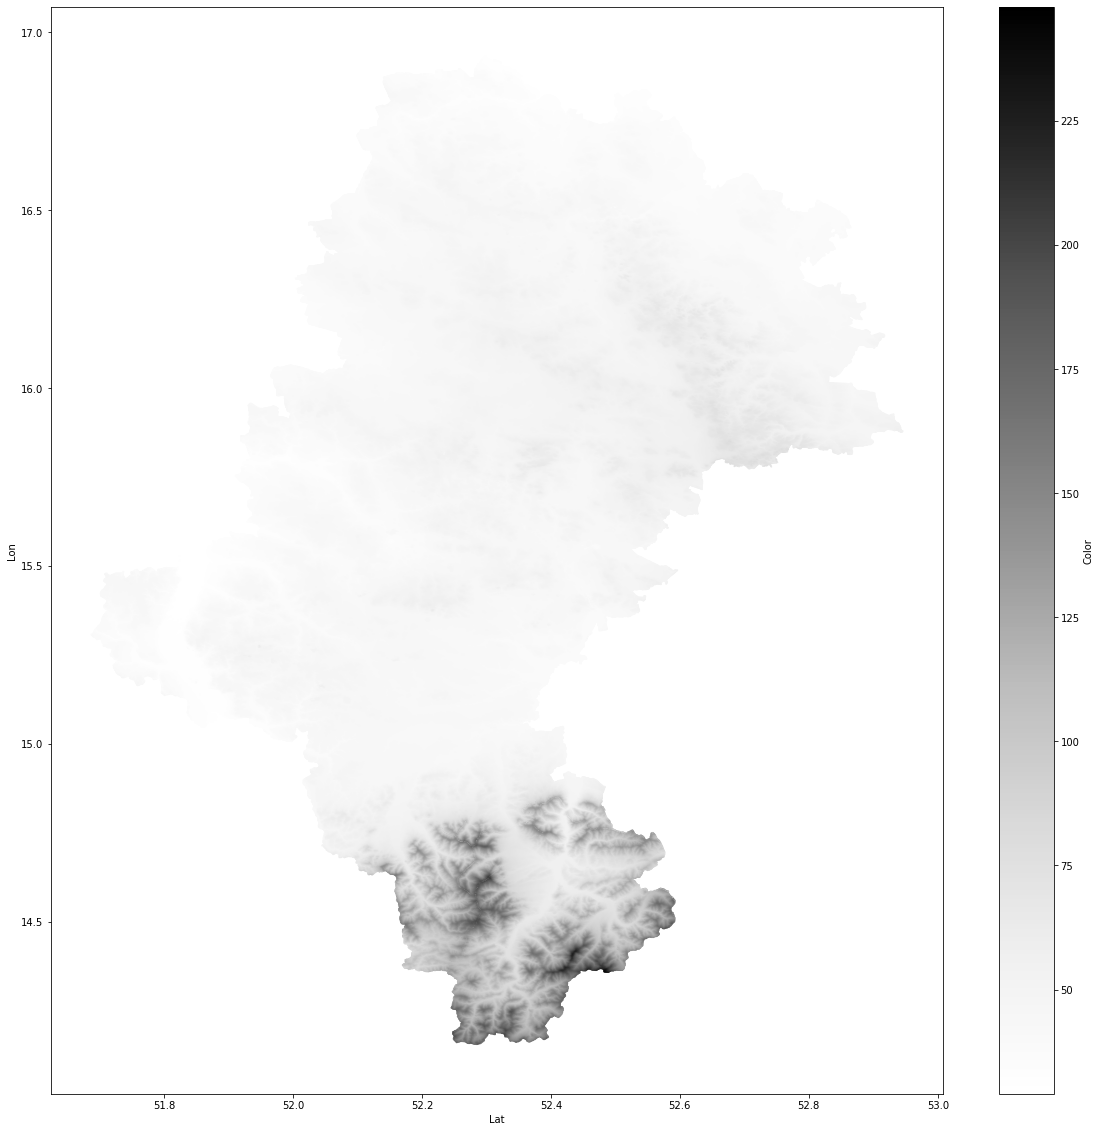

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (20, 20))
wdf.plot(kind='scatter', x='Lat', y='Lon', c='Color', alpha=1, s=0.4, ax = ax)
plt.savefig('./height-map.png', dpi=300, bbox_inches='tight')
plt.show()

In [69]:
plt.close()

## OSMNX

In [3]:
# conda install -c conda-forge osmnx 
import osmnx as ox
place = "Katowice, Poland"

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'name',
                    'highway', 'maxspeed', 'service', 'access', 'area',
                    'landuse', 'width', 'est_width', 'junction', 'surface','traffic_signals','crossing', 'give_way' ]
ox.utils.config(useful_tags_path=useful_tags_path)

# G = ox.graph_from_address('350 5th Ave, New York, New York', network_type='drive')
graph = ox.graph_from_place(place, network_type='drive')

In [ ]:
## dane drogi

In [4]:
nodes, streets = ox.graph_to_gdfs(graph)
streets.sample(5)

,u,v,key,osmid,lanes,surface,highway,name,maxspeed,oneway,length,geometry,junction,tunnel,bridge,access,width
930,1874462688,1860744113,0,296465110,NaN,NaN,residential,Ludwika Zamenhofa,NaN,False,126.012,"LINESTRING (19.10583 50.26294, 19.10486 50.263...",NaN,NaN,NaN,NaN,NaN
1840,347655210,322925228,0,95299927,3,asphalt,secondary,Chorzowska,50,True,33.626,"LINESTRING (19.01230 50.26679, 19.01244 50.266...",NaN,NaN,NaN,NaN,NaN
9380,30177674,516442545,0,"[184042995, 234238780, 184042982, 184042983]","[3, 4]",asphalt,tertiary,Tadeusza Kościuszki,50,False,488.444,"LINESTRING (19.00864 50.24461, 19.00853 50.244...",NaN,NaN,NaN,NaN,NaN
10289,1837481628,1837481607,0,"[51342514, 172908523]",2,NaN,residential,Mikołaja Kopernika,30,False,158.054,"LINESTRING (19.01182 50.25587, 19.01197 50.255...",NaN,NaN,NaN,NaN,NaN
2241,262672261,322482270,0,24261078,1,asphalt,secondary_link,Aleja Górnośląska,NaN,True,124.975,"LINESTRING (19.00024 50.24929, 19.00053 50.249...",NaN,NaN,NaN,NaN,NaN


In [5]:
# https://www.openstreetmap.org/way/238171637
# https://www.openstreetmap.org/query?lat=50.25191&lon=19.02391
# http://overpass-turbo.eu/
    # highway=traffic_signals
    # highway=crossing
    # highway=give_way
    

# https://towardsdatascience.com/loading-data-from-openstreetmap-with-python-and-the-overpass-api-513882a27fd0

# osmid: 51342495 / 238171638
    
streets[streets['name'] == 'Powstańców']

,u,v,key,osmid,lanes,surface,highway,name,maxspeed,oneway,length,geometry,junction,tunnel,bridge,access,width
1030,1927350344,1837481557,0,238171637,3,asphalt,tertiary,Powstańców,50,False,109.807,"LINESTRING (19.02821 50.25166, 19.02741 50.251...",NaN,NaN,NaN,NaN,NaN
1031,1927350344,1837481553,0,"[205489645, 238171637]",3,asphalt,tertiary,Powstańców,50,False,105.285,"LINESTRING (19.02821 50.25166, 19.02862 50.251...",NaN,NaN,NaN,NaN,NaN
1910,1837517954,4077376661,0,172908536,2,asphalt,tertiary,Powstańców,NaN,True,13.301,"LINESTRING (19.03315 50.25125, 19.03297 50.25127)",NaN,NaN,NaN,NaN,NaN
3135,4077376661,2096966277,0,172908536,2,asphalt,tertiary,Powstańców,NaN,True,50.560,"LINESTRING (19.03297 50.25127, 19.03293 50.251...",NaN,NaN,NaN,NaN,NaN
3184,655185124,655185128,0,577690554,NaN,NaN,unclassified,Powstańców,30,True,65.773,"LINESTRING (19.02123 50.25211, 19.02206 50.252...",NaN,NaN,NaN,NaN,NaN
3186,655185128,2121589599,0,51342495,NaN,asphalt,unclassified,Powstańców,30,True,123.523,"LINESTRING (19.02215 50.25204, 19.02222 50.252...",NaN,NaN,NaN,NaN,NaN
5708,2121589598,1837481561,0,238171638,2,asphalt,unclassified,Powstańców,30,True,66.461,"LINESTRING (19.02395 50.25191, 19.02405 50.251...",NaN,NaN,NaN,NaN,NaN
5709,2121589599,2121589598,0,238171638,2,asphalt,unclassified,Powstańców,30,True,5.686,"LINESTRING (19.02387 50.25191, 19.02395 50.25191)",NaN,NaN,NaN,NaN,NaN
6760,2096966263,2096966261,0,205489644,1,asphalt,tertiary,Powstańców,NaN,True,11.053,"LINESTRING (19.03313 50.25116, 19.03328 50.25115)",NaN,NaN,NaN,NaN,NaN
6785,2096966277,2096966263,0,199712525,2,asphalt,tertiary,Powstańców,NaN,True,63.771,"LINESTRING (19.03226 50.25130, 19.03284 50.251...",NaN,NaN,NaN,NaN,NaN


In [8]:
streets.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10538 entries, 0 to 10537
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   u         10538 non-null  int64   
 1   v         10538 non-null  int64   
 2   key       10538 non-null  int64   
 3   osmid     10538 non-null  object  
 4   lanes     2436 non-null   object  
 5   surface   4195 non-null   object  
 6   highway   10538 non-null  object  
 7   name      9320 non-null   object  
 8   maxspeed  3036 non-null   object  
 9   oneway    10538 non-null  bool    
 10  length    10538 non-null  float64 
 11  geometry  10538 non-null  geometry
 12  junction  207 non-null    object  
 13  tunnel    43 non-null     object  
 14  bridge    193 non-null    object  
 15  access    106 non-null    object  
 16  width     1 non-null      object  
dtypes: bool(1), float64(1), geometry(1), int64(3), object(11)
memory usage: 1.3+ MB


In [7]:
streets[(streets.osmid == 51342495) | (streets.osmid == 238171638)]

,u,v,key,osmid,lanes,surface,highway,name,maxspeed,oneway,length,geometry,junction,tunnel,bridge,access,width
3186,655185128,2121589599,0,51342495,NaN,asphalt,unclassified,Powstańców,30,True,123.523,"LINESTRING (19.02215 50.25204, 19.02222 50.252...",NaN,NaN,NaN,NaN,NaN
5708,2121589598,1837481561,0,238171638,2,asphalt,unclassified,Powstańców,30,True,66.461,"LINESTRING (19.02395 50.25191, 19.02405 50.251...",NaN,NaN,NaN,NaN,NaN
5709,2121589599,2121589598,0,238171638,2,asphalt,unclassified,Powstańców,30,True,5.686,"LINESTRING (19.02387 50.25191, 19.02395 50.25191)",NaN,NaN,NaN,NaN,NaN
10188,1837481561,1837481558,0,238171638,2,asphalt,unclassified,Powstańców,30,True,51.379,"LINESTRING (19.02488 50.25183, 19.02501 50.251...",NaN,NaN,NaN,NaN,NaN


## Folium

In [2]:
#19*00'551 (E) 	50*16'127 (N) 	KATOWICE 	JANA NEPOMUCENA STĘŚLICKIEGO

m = folium.Map(
    location=[50.25188888888889, 19.023916666666665],
    zoom_start=20,
    tiles='Stamen Terrain'
)

tooltip = 'Wypadek'

folium.Marker([50.25188888888889, 19.023916666666665], popup='<i>ID : </i>', tooltip=tooltip).add_to(m)
#folium.Marker([45.3311, -121.7113], popup='<b>Timberline Lodge</b>', tooltip=tooltip).add_to(m)

m